# Sparse Stochastic Variational Inference

In this notebook we demonstrate how to implement sparse variational Gaussian processes (SVGPs) of <strong data-cite="hensman2013gaussian">Hensman et al. (2013)</strong>; <strong data-cite="hensman2015gaussian">Hensman et al. (2015)</strong>. In particular, this approximation framework provides a tractable option for working with non-conjugate Gaussian processes with more than ~5000 data points. However, for conjugate models of less than 5000 data points, we recommend using the marginal log-likelihood approach presented in the [regression notebook](https://gpjax.readthedocs.io/en/latest/nbs/regression.html). Though we illustrate SVGPs here with a conjugate regression example, the same GPJax code works for general likelihoods, such as a Bernoulli for classification.

In [1]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax as ox
from jax import jit
from jax.config import config
from jaxutils import Dataset
import jaxkern as jk

import tensorflow_probability.substrates.jax as tfp

tfb = tfp.bijectors

import distrax as dx
import gpjax as gpx
from gpjax.config import get_global_config, reset_global_config

# Enable Float64 for more stable matrix inversions.
config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)

## Dataset

With the necessary modules imported, we simulate a dataset $\mathcal{D} = (\boldsymbol{x}, \boldsymbol{y}) = \{(x_i, y_i)\}_{i=1}^{5000}$ with inputs $\boldsymbol{x}$ sampled uniformly on $(-5, 5)$ and corresponding binary outputs

$$\boldsymbol{y} \sim \mathcal{N} \left(\sin(4 * \boldsymbol{x}) + \sin(2 * \boldsymbol{x}), \textbf{I} * (0.2)^{2} \right).$$

We store our data $\mathcal{D}$ as a GPJax `Dataset` and create test inputs for later.

In [2]:
n = 5000
noise = 0.2

x = jr.uniform(key=key, minval=-5.0, maxval=5.0, shape=(n,)).sort().reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise

D = Dataset(X=x, y=y)

xtest = jnp.linspace(-5.5, 5.5, 500).reshape(-1, 1)

## Sparse GPs via inducing inputs

Despite their endowment with elegant theoretical properties, GPs are burdened with prohibitive $\mathcal{O}(n^3)$ inference and $\mathcal{O}(n^2)$ memory costs in the number of data points $n$ due to the necessity of computing inverses and determinants of the kernel Gram matrix $\mathbf{K}_{\boldsymbol{x}\boldsymbol{x}}$ during inference and hyperparameter learning.
Sparse GPs seek to resolve tractability through low-rank approximations.

Their name originates with the idea of using subsets of the data to approximate the kernel matrix, with _sparseness_ occurring through the selection of the data points.
Given inputs $\boldsymbol{x}$ and outputs $\boldsymbol{y}$ the task was to select an $m<n$ lower-dimensional dataset $(\boldsymbol{z},\boldsymbol{\tilde{y}}) \subset (\boldsymbol{x}, \boldsymbol{y})$ to train a Gaussian process on instead.
By generalising the set of selected points $\boldsymbol{z}$, known as _inducing inputs_, to remove the restriction of being part of the dataset,
we can arrive at a flexible low-rank approximation framework of the model using functions of $\mathbf{K}_{\boldsymbol{z}\boldsymbol{z}}$ to replace the true covariance matrix $\mathbf{K}_{\boldsymbol{x}\boldsymbol{x}}$ at significantly lower costs. For example, <strong data-cite="quinonero-candela2005gaussian"></strong> review many popular approximation schemes in this vein. However, because the model and the approximation are intertwined, assigning performance and faults to one or the other becomes tricky.

On the other hand, sparse variational Gaussian processes (SVGPs) [approximate the posterior, not the model](https://www.secondmind.ai/labs/sparse-gps-approximate-the-posterior-not-the-model/).
These provide a low-rank approximation scheme via variational inference. Here we posit a family of densities parameterised by “variational parameters”.
We then seek to find the closest family member to the posterior by minimising the Kullback-Leibler divergence over the variational parameters.
The fitted variational density then serves as a proxy for the exact posterior.
This procedure makes variational methods efficiently solvable via off-the-shelf optimisation techniques whilst retaining the true-underlying model.
Furthermore, SVGPs offer further cost reductions with mini-batch stochastic gradient descent  <strong data-cite="hensman2013gaussian"></strong> and address non-conjugacy <strong data-cite="hensman2015gaussian"></strong>.
We show a cost comparison between the approaches below, where $b$ is the mini-batch size.



|    | GPs | sparse GPs | SVGP |
| -- | -- | -- | -- |
| Inference cost | $\mathcal{O}(n^3)$ | $\mathcal{O}(n m^2)$ | $\mathcal{O}(b m^2 + m^3)$  |
| Memory cost    | $\mathcal{O}(n^2)$ | $\mathcal{O}(n m)$ | $\mathcal{O}(b m + m^2)$ |


To apply SVGP inference to our dataset, we begin by initialising $m = 50$ equally spaced inducing inputs $\boldsymbol{z}$ across our observed data's support. These are depicted below via horizontal black lines.

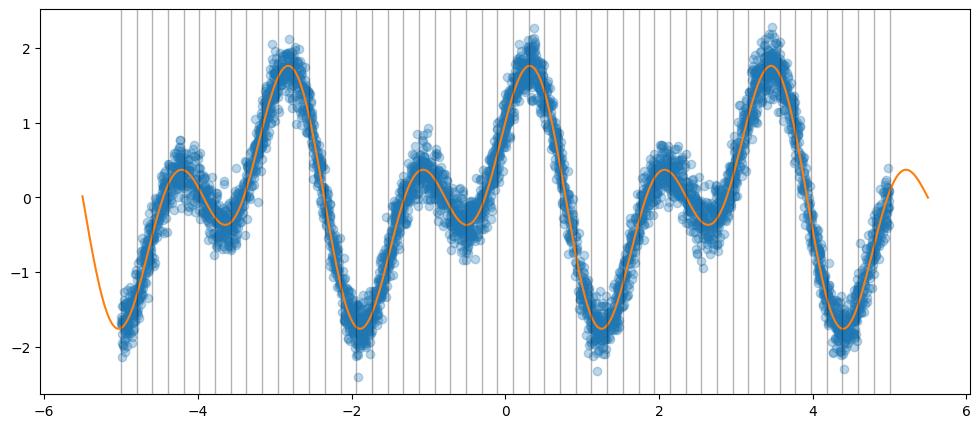

In [3]:
z = jnp.linspace(-5.0, 5.0, 50).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", alpha=0.3)
ax.plot(xtest, f(xtest))
[ax.axvline(x=z_i, color="black", alpha=0.3, linewidth=1) for z_i in z]
plt.show()

The inducing inputs will summarise our dataset, and since they are treated as variational parameters, their locations will be optimised. The next step to SVGP is to define a variational family.

## Defining the variational process

We begin by considering the form of the posterior distribution for all function values $f(\cdot)$

\begin{align}
p(f(\cdot) | \mathcal{D}) = \int p(f(\cdot)|f(\boldsymbol{x})) p(f(\boldsymbol{x})|\mathcal{D}) \text{d}f(\boldsymbol{x}). \qquad (\dagger)
\end{align}

To arrive at an approximation framework, we assume some redundancy in the data. Instead of predicting $f(\cdot)$ with function values at the datapoints $f(\boldsymbol{x})$, we assume this can be achieved with only function values at $m$ inducing inputs $\boldsymbol{z}$

$$ p(f(\cdot) | \mathcal{D}) \approx \int p(f(\cdot)|f(\boldsymbol{z})) p(f(\boldsymbol{z})|\mathcal{D}) \text{d}f(\boldsymbol{z}). \qquad (\star) $$

This lower dimensional integral results in computational savings in the model's predictive component from $p(f(\cdot)|f(\boldsymbol{x}))$ to $p(f(\cdot)|f(\boldsymbol{z}))$ where inverting $\mathbf{K}_{\boldsymbol{x}\boldsymbol{x}}$ is replaced with inverting $\mathbf{K}_{\boldsymbol{z}\boldsymbol{z}}$.
However, since we did not observe our data $\mathcal{D}$ at $\boldsymbol{z}$ we ask, what exactly is the posterior $p(f(\boldsymbol{z})|\mathcal{D})$?

Notice this is simply obtained by substituting $\boldsymbol{z}$ into $(\dagger)$, but we arrive back at square one with computing the expensive integral. To side-step this, we consider replacing $p(f(\boldsymbol{z})|\mathcal{D})$ in $(\star)$ with a cheap-to-compute approximate distribution $q(f(\boldsymbol{z}))$

  $$ q(f(\cdot)) = \int p(f(\cdot)|f(\boldsymbol{z})) q(f(\boldsymbol{z})) \text{d}f(\boldsymbol{z}). \qquad (\times) $$

To measure the quality of the approximation, we consider the Kullback-Leibler divergence $\operatorname{KL}(\cdot || \cdot)$ from our approximate process $q(f(\cdot))$ to the true process $p(f(\cdot)|\mathcal{D})$. By parametrising $q(f(\boldsymbol{z}))$ over a variational family of distributions, we can optimise Kullback-Leibler divergence with respect to the variational parameters. Moreover, since inducing input locations $\boldsymbol{z}$ augment the model, they themselves can be treated as variational parameters without altering the true underlying model $p(f(\boldsymbol{z})|\mathcal{D})$. This is exactly what gives SVGPs great flexibility whilst retaining robustness to overfitting.

It is popular to elect a Gaussian variational distribution $q(f(\boldsymbol{z})) = \mathcal{N}(f(\boldsymbol{z}); \mathbf{m}, \mathbf{S})$ with parameters $\{\boldsymbol{z}, \mathbf{m}, \mathbf{S}\}$, since conjugacy is provided between $q(f(\boldsymbol{z}))$ and $p(f(\cdot)|f(\boldsymbol{z}))$ so that the resulting variational process $q(f(\cdot))$ is a GP. We can implement this in GPJax by the following.

In [4]:
likelihood = gpx.Gaussian(num_datapoints=n)
prior = gpx.Prior(kernel=jk.RBF())
p = prior * likelihood
q = gpx.VariationalGaussian(prior=prior, inducing_inputs=z)

Here, the variational process $q(\cdot)$ depends on the prior through $p(f(\cdot)|f(\boldsymbol{z}))$ in $(\times)$.


We combine our true and approximate posterior Gaussian processes into an `StochasticVI` object to define the variational strategy that we will adopt in the forthcoming inference.

In [5]:
svgp = gpx.StochasticVI(posterior=p, variational_family=q)

## Inference

### Evidence lower bound

With our model defined, we seek to infer the optimal inducing inputs $\boldsymbol{z}$, variational mean $\mathbf{m}$ and covariance $\mathbf{S}$ that define our approximate posterior. To achieve this, we maximise the evidence lower bound (ELBO) with respect to $\{\boldsymbol{z}, \mathbf{m}, \mathbf{S} \}$, a proxy for minimising the Kullback-Leibler divergence. Moreover, as hinted by its name, the ELBO is a lower bound to the marginal log-likelihood, providing a tractable objective to optimise the model's hyperparameters akin to the conjugate setting. For further details on this, see Sections 3.1 and 4.1 of the excellent review paper <strong data-cite="leibfried2020tutorial"></strong>.

Since Optax's optimisers work to minimise functions, to maximise the ELBO we return its negative.

In [6]:
negative_elbo = jit(svgp.elbo(D, negative=True))

### Mini-batching

Despite introducing inducing inputs into our model, inference can still be intractable with large datasets. To circumvent this, optimisation can be done using stochastic mini-batches.

In [7]:
reset_global_config()
parameter_state = gpx.initialise(svgp, key)
optimiser = ox.adam(learning_rate=0.01)

inference_state = gpx.fit_batches(
    objective=negative_elbo,
    parameter_state=parameter_state,
    train_data=D,
    optax_optim=optimiser,
    num_iters=3000,
    key=jr.PRNGKey(42),
    batch_size=128,
)

learned_params, training_history = inference_state.unpack()

/var/folders/qb/c3b8rx055411rkfvdyzty9_80000gn/T/ipykernel_99271/3641125512.py:1: DeprecatedWarning: reset_global_config is deprecated as of 0.5.6 and will be removed in 0.6.0. Use method from jaxutils.config instead.
  reset_global_config()


  0%|          | 0/3000 [00:00<?, ?it/s]

## Predictions

With optimisation complete, we can use our inferred parameter set to make predictions at novel inputs akin
to all other models within GPJax on our variational process object $q(\cdot)$ (for example, see the [regression notebook](https://gpjax.readthedocs.io/en/latest/nbs/regression.html)).

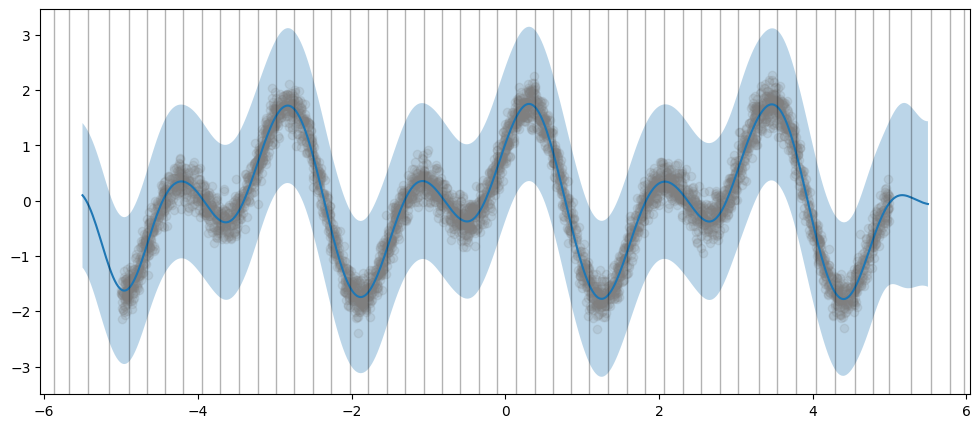

In [8]:
latent_dist = q(learned_params)(xtest)
predictive_dist = likelihood(learned_params, latent_dist)

meanf = predictive_dist.mean()
sigma = predictive_dist.stddev()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", alpha=0.15, label="Training Data", color="tab:gray")
ax.plot(xtest, meanf, label="Posterior mean", color="tab:blue")
ax.fill_between(xtest.flatten(), meanf - sigma, meanf + sigma, alpha=0.3)
[
    ax.axvline(x=z_i, color="black", alpha=0.3, linewidth=1)
    for z_i in learned_params["variational_family"]["inducing_inputs"]
]
plt.show()

## Custom transformations

To train a covariance matrix, GPJax uses `tfb.FillScaleTriL` transformation by default. `tfb.FillScaleTriL` fills a 1d vector into a lower triangular matrix and then applies `Softplus` transformation on the diagonal to satisfy the necessary conditions for a valid Cholesky matrix. Users can change this default transformation with another valid transformation of their choice. For example, `Square` transformation on the diagonal can also serve the purpose.

In [9]:
gpx_config = get_global_config()
transformations = gpx_config.transformations
jitter = gpx_config.jitter

triangular_transform = dx.Chain(
    [tfb.FillScaleTriL(diag_bijector=tfb.Square(), diag_shift=jnp.array(jitter))]
)

transformations.update({"triangular_transform": triangular_transform})

/var/folders/qb/c3b8rx055411rkfvdyzty9_80000gn/T/ipykernel_99271/780363273.py:1: DeprecatedWarning: get_global_config is deprecated as of 0.5.6 and will be removed in 0.6.0. Use method from jaxutils.config instead.
  gpx_config = get_global_config()


In [10]:
parameter_state = gpx.initialise(svgp, key)
optimiser = ox.adam(learning_rate=0.01)

inference_state = gpx.fit_batches(
    objective=negative_elbo,
    parameter_state=parameter_state,
    train_data=D,
    optax_optim=optimiser,
    num_iters=3000,
    key=jr.PRNGKey(42),
    batch_size=128,
)

learned_params, training_history = inference_state.unpack()

  0%|          | 0/3000 [00:00<?, ?it/s]

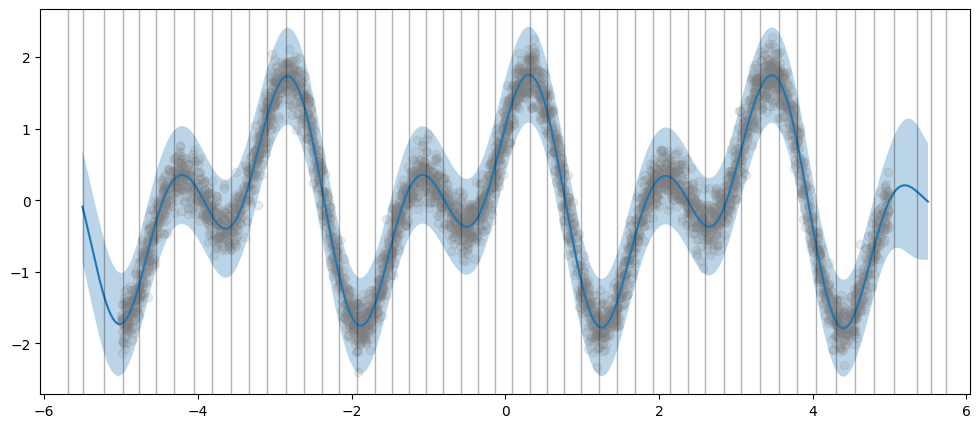

In [11]:
latent_dist = q(learned_params)(xtest)
predictive_dist = likelihood(learned_params, latent_dist)

meanf = predictive_dist.mean()
sigma = predictive_dist.stddev()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(x, y, "o", alpha=0.15, label="Training Data", color="tab:gray")
ax.plot(xtest, meanf, label="Posterior mean", color="tab:blue")
ax.fill_between(xtest.flatten(), meanf - sigma, meanf + sigma, alpha=0.3)
[
    ax.axvline(x=z_i, color="black", alpha=0.3, linewidth=1)
    for z_i in learned_params["variational_family"]["inducing_inputs"]
]
plt.show()

We can see that `Square` transformation is able to get relatively better fit compared to `Softplus` with the same number of iterations, but `Softplus` is recommended over `Square` for stability of optimisation.

## System configuration

In [12]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Thomas Pinder, Daniel Dodd & Zeel B Patel'

Author: Thomas Pinder, Daniel Dodd & Zeel B Patel

Last updated: Sat Jan 14 2023

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.8.0

jax                   : 0.4.1
jaxkern               : 0.0.4
optax                 : 0.1.4
gpjax                 : 0.5.8
tensorflow_probability: 0.19.0
distrax               : 0.1.2
matplotlib            : 3.3.3

Watermark: 2.3.1

